<a href="https://colab.research.google.com/github/huyiscool/Lab3/blob/main/AOR_VC_Distances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import urllib.parse
from google.colab import userdata


DISTANCE_API_KEY = userdata.get('GoogleMapsAPI')
AOR_VOTECENTER_MAP_FILE = 'AOR_Maps.xlsx'
GOOGLE_MAP_URL_PREFIX = "https://www.google.com/maps/dir/?"
HYPERLINK_FORMULA_PREFIX = '=HYPERLINK('


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Main - prepare DF for output

In [ ]:
# create vote center DF from Excel file or google sheet on google drive
def get_vcs(filename, gsheet=None):
    if gsheet is None:
      all_vc = pd.read_excel(filename,0)
    else:
      all_vc = pd.DataFrame.from_dict(gsheet.get_all_records())

    # rename columns
    all_vc.columns = ['AOR','Code','Name','Street','CityZip']

    # add Address
    all_vc['Address'] = all_vc['Street'] + ', ' + all_vc['CityZip']

    # VC Code + Address
    all_vc['Name'] = all_vc['Code'] + "\n\n" + all_vc['Address']

    # drop the useless
    all_vc.drop("Street", axis=1, inplace=True)
    all_vc.drop("CityZip", axis=1, inplace=True)

    return all_vc

#url for google direction from origin to destination by car
def gmap_url(row):
  return GOOGLE_MAP_URL_PREFIX + urllib.parse.urlencode({"api":1, "travelmode":"driving", "origin":row['Address'],"destination":row['Address_2']})

#excel formula of a hyperlink
def gmap_link(row):
  url = GOOGLE_MAP_URL_PREFIX + urllib.parse.urlencode({"api":1, "travelmode":"driving", "origin":row['Address'],"destination":row['Address_2']})
  return HYPERLINK_FORMULA_PREFIX + '"' + url + '","' + row['Code'] + ' to ' + row['Code_2'] + '")'

# https://stackoverflow.com/questions/45426843/cartesian-product-of-a-pandas-dataframe-with-itself
def distances_within_aor(aor, df_vc):

  aor_vc = df_vc[df_vc['AOR']==aor]
  if aor_vc.empty:
    print("NO vote centers found for aor" + aor)

  i, j = np.where(np.triu(1 - np.eye(len(aor_vc))))
  df_dist = aor_vc.iloc[i].reset_index(drop=True).join(
            aor_vc.iloc[j].reset_index(drop=True), rsuffix='_2')

  #df_dist['url'] = df1_dist.apply(gmap_url, axis=1)
  df_dist['Map Link'] = df_dist.apply(gmap_link, axis=1)

  df_dist.rename(columns = {'Name':'From VC', 'Name_2':'To VC'}, inplace = True)

  #add placeholders
  df_dist['Distance (miles)'] = ''
  df_dist['Google Map'] = ''

  #drop the useless
  df_dist.drop('Code', axis=1, inplace=True)
  df_dist.drop('Address', axis=1, inplace=True)
  df_dist.drop('AOR_2', axis=1, inplace=True)
  df_dist.drop('Code_2', axis=1, inplace=True)
  df_dist.drop('Address_2', axis=1, inplace=True)

  return df_dist

Distance API function creation to find min distance between VCs

In [ ]:
import requests

#Distance Function Parameters
def get_distance(api_key, origins, destinations):
    url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    params = {
        "origins": origins,
        "destinations": destinations,
        "key": DISTANCE_API_KEY,
        "mode": "driving"  # Specify driving mode
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None




## Output to new worksheet in Excel

In [ ]:
# #output vc distances to a new tab in the source Excel file
# def distances_to_excel(df, filename=AOR_VOTECENTER_MAP_FILE, sheetname='Vote Center Distances'):
#     with pd.ExcelWriter(filename, mode='a') as writer:
#         df.to_excel(writer, sheetname, index=False)



In [ ]:
# distances_to_excel(df)

## Output DF to MS Word - work in progress

* code below was only tried on local MacOS. probably it won't work in Colab
* you need to run the first section and populate dataframe df

In [ ]:
# #!pip install python-docx
# from docx import Document
# from docx.shared import Inches, Cm
# #from docx.enum.table import WD_TABLE_BORDER

# AOR_VOTECENTER_DISTANCES_FILE='vc_distances_test.docx'

# #output vc distances to a new word document
# def distances_to_word(df, filename=AOR_VOTECENTER_DISTANCES_FILE):
#     nRows = df.shape[0]
#     nCols = df.shape[1]

#     doc = Document()
#     table = doc.add_table(nRows+1, nCols, style='Table Grid')

#     #TODO: resize table row height and column widths

#     header_cells = table.rows[0].cells
#     for i, column_name in enumerate(df.columns):
#         header_cells[i].text = column_name

#     #tips from https://github.com/python-openxml/python-docx/issues/174
#     table_cells = table._cells

#     #TODO: add google map hyperlinks
#     #TODO: add screenshot and resize to fit in the table cell
#     #see https://github.com/python-openxml/python-docx/issues/1041
#     for i in range(nRows):
#         row_cells = table_cells[(i+1)*nCols:(i+2)*nCols]
#         for j, value in enumerate(df.iloc[i]):
#             row_cells[j].text = str(value)


#     #TODO: add header and footer


#     #set margins
#     sections = doc.sections
#     for section in sections:
#         section.top_margin = Inches(0.2)
#         section.bottom_margin = Inches(0.2)
#         section.left_margin = Inches(0.2)
#         section.right_margin = Inches(0.2)


#     doc.save(filename)

In [ ]:
# distances_to_word(df)

## Work with Google Colab and Sheets on Google Drive

* sign in to your google account
* make sure google sheet 'AOR_Maps' is on your google drive
* run the cell and grant access to your google drive and docs
* all of the code in the MAIN section can be reused, except when calling get_vcs() passing in the gsheet name and gsheet obj


In [ ]:
# using Google Drive and Colab notebook
#!pip install gspread
#!pip install oauth2client
#!pip install requests

from google.colab import drive
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseUpload
from google.auth import default
import gspread

# mount google drive so we can access the files
drive.mount("/content/drive/")

auth.authenticate_user()

creds, _ = default()
drive_service = build('drive', 'v3', credentials=creds)
gclient = gspread.authorize(creds)

gwkbook = gclient.open("AOR_Maps")
gvcsheet = gwkbook.get_worksheet(0)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
gvcsheet

<Worksheet 'AOR Map' id:551247849>

# Distance Calculation

In [ ]:
#vote centers in the data file
all_vc = get_vcs("AOR_Maps", gvcsheet)
aor_list = all_vc['AOR'].unique()

#df has the vote center pairs for all AORs
df = pd.DataFrame()
df_list = []
for aor in aor_list:
    aor_df = distances_within_aor(aor, all_vc)
    # Iterate through each row in aor_df to calculate distances
    for index in aor_df.index:
        # Get the 'From VC' and 'To VC' values from the DataFrame
        from_vc = aor_df.at[index, 'From VC']
        from_vc = from_vc[7:] #remove VC num
        print('From ')
        print(from_vc)
        to_vc = aor_df.at[index, 'To VC']
        print('To ')
        to_vc = to_vc[7:] #remove VC num
        print(to_vc)

        # Call the Google Distance Matrix API
        result = get_distance(DISTANCE_API_KEY, from_vc, to_vc)
        if result and result['rows'][0]['elements'][0]['status'] == 'OK':
            distance = result['rows'][0]['elements'][0]['distance']['value']  # Distance in meters
        else:
            # Handle cases where the API response is not valid
            distance = None

        # Update the 'Distance' column in aor_df with the calculated distance
        aor_df.at[index, 'Distance (miles)'] = round((distance*0.000621371),1) #convert to miles

    df_list.append(aor_df)

# Concatenate all DataFrames after the loop to minimize performance overhead
df = pd.concat(df_list, ignore_index=True)

From 
1313 Newell Rd, Palo Alto, CA 94303
To 
3700 Middlefield Rd, Palo Alto, CA 94303
From 
1313 Newell Rd, Palo Alto, CA 94303
To 
2751 Louis Rd, Palo Alto, CA 94303
From 
1313 Newell Rd, Palo Alto, CA 94303
To 
3990 Ventura Ct, Palo Alto, CA 94306
From 
3700 Middlefield Rd, Palo Alto, CA 94303
To 
2751 Louis Rd, Palo Alto, CA 94303
From 
3700 Middlefield Rd, Palo Alto, CA 94303
To 
3990 Ventura Ct, Palo Alto, CA 94306
From 
2751 Louis Rd, Palo Alto, CA 94303
To 
3990 Ventura Ct, Palo Alto, CA 94306
From 
459 Lagunita Dr, Stanford, CA 94305
To 
4249 El Camino Real, Palo Alto, CA 94306
From 
459 Lagunita Dr, Stanford, CA 94305
To 
800 Barron Ave, Palo Alto, CA 94306
From 
4249 El Camino Real, Palo Alto, CA 94306
To 
800 Barron Ave, Palo Alto, CA 94306
From 
201 S Rengstorff Ave, Mountain View, CA 94040
To 
26379 Fremont Rd, Los Altos Hills, CA 94022
From 
201 S Rengstorff Ave, Mountain View, CA 94040
To 
373 Pine Ln, Los Altos, CA 94022
From 
201 S Rengstorff Ave, Mountain View, CA 94

# Export to Sheets

In [ ]:
# csv_file = 'data_export.csv'
# df.to_csv(csv_file, index=False)

# from google.colab import files

# files.download(csv_file)  # Downloads the CSV file


In [ ]:
print(df.shape)
df.head(8)

(203, 6)


,AOR,From VC,To VC,Map Link,Distance (miles),Google Map
0,1,"0102M\n\n1313 Newell Rd, Palo Alto, CA 94303","0104F\n\n3700 Middlefield Rd, Palo Alto, CA 94303","=HYPERLINK(""https://www.google.com/maps/dir/?a...",2.4,
1,1,"0102M\n\n1313 Newell Rd, Palo Alto, CA 94303","0117F\n\n2751 Louis Rd, Palo Alto, CA 94303","=HYPERLINK(""https://www.google.com/maps/dir/?a...",1.0,
2,1,"0102M\n\n1313 Newell Rd, Palo Alto, CA 94303","0401M\n\n3990 Ventura Ct, Palo Alto, CA 94306","=HYPERLINK(""https://www.google.com/maps/dir/?a...",3.3,
3,1,"0104F\n\n3700 Middlefield Rd, Palo Alto, CA 94303","0117F\n\n2751 Louis Rd, Palo Alto, CA 94303","=HYPERLINK(""https://www.google.com/maps/dir/?a...",2.1,
4,1,"0104F\n\n3700 Middlefield Rd, Palo Alto, CA 94303","0401M\n\n3990 Ventura Ct, Palo Alto, CA 94306","=HYPERLINK(""https://www.google.com/maps/dir/?a...",1.7,
5,1,"0117F\n\n2751 Louis Rd, Palo Alto, CA 94303","0401M\n\n3990 Ventura Ct, Palo Alto, CA 94306","=HYPERLINK(""https://www.google.com/maps/dir/?a...",2.7,
6,2,"0103F\n\n459 Lagunita Dr, Stanford, CA 94305","0115F\n\n4249 El Camino Real, Palo Alto, CA 94306","=HYPERLINK(""https://www.google.com/maps/dir/?a...",4.8,
7,2,"0103F\n\n459 Lagunita Dr, Stanford, CA 94305","0119F\n\n800 Barron Ave, Palo Alto, CA 94306","=HYPERLINK(""https://www.google.com/maps/dir/?a...",3.3,


In [ ]:
# # Create a new sheet
# gdsheet = gwkbook.add_worksheet(title='Vote Center Distances', rows=df.shape[0]+2, cols=df.shape[1])

# gdsheet.update([df.columns.values.tolist()] + df.values.tolist(), raw=False)



## Selenium to capture Google Map screenshot for given URL

* code below was only tried on local MacOS. probably it won't work on Colab.
* haven't tried to add the screenshot to DF yet

In [ ]:
!pip install selenium
!pip install webdriver_manager
!pip install Pillow
#download chromedriver and add its location to PATH (/usr/local/bin, for example)


from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


from PIL import Image
import io
import time
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00


In [ ]:
!apt-get update
!apt-get install -y chromium-browser

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [57.7 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 http://secur

In [ ]:
#Establish parameters for options to initialize webdriver
#No sandbox fixed allowed the Chromedriver to connect to Chrome
options = webdriver.ChromeOptions()
options.add_argument('--headless=new')
options.add_argument('--no-sandbox')
driver = webdriver.Chrome(options=options)
!pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib





# Upload Dataframe to Google Sheets

In [ ]:
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from google.colab import files
# Upload the service account JSON file (Have to do this once at initialization)
uploaded = files.upload()

# List uploaded files to check the file name
# print("Uploaded files:")
# print(os.listdir())

# Define the scope and authenticate
#TODO Create Service Account for County
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
SERVICE_ACCOUNT_FILE = userdata.get('ServiceAccountFile') # Huy's Service Account

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('sheets', 'v4', credentials=creds)

# Define your spreadsheet ID and range
spreadsheet_id = '1zYgIIDVAZGE955tGiuscITnK0tIZl7uqqN8eRz5kYRs'  # Google Sheet ID
range_name = 'data_export 2!A1'  # Name of Google Sheet + starting range


# Convert DataFrame to a list of lists and include headers
data = df.values.tolist()
data.insert(0, df.columns.tolist())  # Add header row

# Create the request body
body = {
    'values': data
}

# Update the sheet with the DataFrame data
try:
    result = service.spreadsheets().values().update(
        spreadsheetId=spreadsheet_id,
        range=range_name,
        valueInputOption='USER_ENTERED',
        body=body
    ).execute()
    print(f"{result.get('updatedCells')} cells updated.")
except Exception as e:
    print(f"An error occurred: {e}")



KeyboardInterrupt



# Upload Screenshots to Google Sheets #TODO RESIZE IMAGE

In [ ]:
#Establish folder path in Google Drive to save the generated screenshots
sheets_service = build('sheets', 'v4', credentials=creds)

folder_name = 'AOR_Screenshots'
response = drive_service.files().list(q=f"name='{folder_name}' and mimeType='application/vnd.google-apps.folder'",
                                          spaces='drive',
                                          fields='nextPageToken, files(id, name)').execute()
drive_id = response.get('driveId')
items = response.get('files', [])
if not items:
    print(f"No folder named '{folder_name}' found. Creating a new one.")
    # Create the folder in Google Drive if it doesn't exist
    folder_metadata = {
    'name': folder_name,
    'mimeType': 'application/vnd.google-apps.folder',
    'parents': [parent_folder_id]
    }
    folder = drive_service.files().create(body=folder_metadata, fields='id').execute()
    folder_id = folder.get('id')

else:
    folder_id = items[0]['id']
    print(f"Found shared folder '{folder_name}' with ID: {folder_id}")

aor_df = aor_df.reset_index(drop=True) #Reset index for dataframe
# print("Dataframe Shape: " + aor_df.shape())
for index, row in df.iterrows():

    from_vc = row['From VC'][7:]  # Remove VC num
    to_vc = row['To VC'][7:]      # Remove VC num
    url_gmap = row['Map Link'][12:-2]  # Clean URL
    print(url_gmap)
    try:
        print("I'm trying")
        driver = webdriver.Chrome(options=options) #re-initialize the driver for each iteration
        driver.get(url_gmap)
        time.sleep(1)

    finally:
        # get Screenshot
        print('Getting screenshot')
        img = Image.open(io.BytesIO(driver.get_screenshot_as_png()))
        #Convert img to img_bytes for export to Drive
        img_bytes = io.BytesIO()
        img.save(img_bytes, format='PNG')
        img_bytes.seek(0)
        #Create and format img file name
        file_name = from_vc + to_vc + '.png'
        file_name = file_name.replace(' ', '_').replace(',', '_')
        file_name = from_vc + to_vc + '.png'
        file_name = file_name.replace(' ', '_').replace(',', '_')
        file_metadata = {
            'name': file_name,
            'parents': [folder_id],  # Use the ID of the created folder
            'driveId' : drive_id

        }
        # Upload the screenshot to Google Drive
        media = MediaIoBaseUpload(img_bytes, mimetype='image/png')
        file = drive_service.files().create(body=file_metadata,
                                            media_body=media,
                                            fields='id', supportsAllDrives=True).execute()
        print(f'File ID: {file.get("id")}')

        image_url = f"https://drive.google.com/uc?id={file.get('id')}"

        # Insert the image URL into Google Sheets
        spreadsheet_id = '1zYgIIDVAZGE955tGiuscITnK0tIZl7uqqN8eRz5kYRs'  # Google Sheet ID
        range_name = f'data_export 2!F{index + 2}'  # Name of sheet + starting index
        print(f'Image URL: {image_url}')

        # Create the request body to insert the IMAGE formula
        body = {
            'values': [[f'=IMAGE("{image_url}", 1)']]  # Inserting the IMAGE formula
        }

        # Update the Google Sheet with the image formula
        sheets_service.spreadsheets().values().update(
            spreadsheetId=spreadsheet_id,
            range=range_name,
            valueInputOption='USER_ENTERED',
            body=body
        ).execute()

        driver.quit()


Found shared folder 'AOR_Screenshots' with ID: 1p4qvpv4K54bDa6p8ltG0AhP_g-bTz2aM
I'm trying
Getting screenshot
File ID: 1rTplyLOwqQJ8QIcwbejvk00sX_qIx9yx
Image URL: https://drive.google.com/uc?id=1rTplyLOwqQJ8QIcwbejvk00sX_qIx9yx
I'm trying
Getting screenshot
File ID: 1h1udCmnjJb1UEbXXUfEkqiVeWaPMu6IZ
Image URL: https://drive.google.com/uc?id=1h1udCmnjJb1UEbXXUfEkqiVeWaPMu6IZ
I'm trying
Getting screenshot
File ID: 1JOliTMk2X4w9OCnQw1QWon7j2r4r8CLP
Image URL: https://drive.google.com/uc?id=1JOliTMk2X4w9OCnQw1QWon7j2r4r8CLP
I'm trying
Getting screenshot
File ID: 1n4jwrP3mW6B0PGAdzePywP1oNHpLETe6
Image URL: https://drive.google.com/uc?id=1n4jwrP3mW6B0PGAdzePywP1oNHpLETe6
I'm trying
Getting screenshot
File ID: 1kviTciyi-N0KOs6SHQrhbiO_X0r94bdE
Image URL: https://drive.google.com/uc?id=1kviTciyi-N0KOs6SHQrhbiO_X0r94bdE
I'm trying
Getting screenshot
File ID: 1cNix_Ct8Qj9XbjIxSiiTDeEK5Odrdyvt
Image URL: https://drive.google.com/uc?id=1cNix_Ct8Qj9XbjIxSiiTDeEK5Odrdyvt
I'm trying
Getting screen

# Find SheetId

In [ ]:
# Fetch spreadsheet details
spreadsheet = service.spreadsheets().get(spreadsheetId=SPREADSHEET_ID).execute()
sheets = spreadsheet.get('sheets', [])

for sheet in sheets:
    print(f"Sheet Title: {sheet['properties']['title']}, Sheet ID: {sheet['properties']['sheetId']}")


Sheet Title: data_export 2, Sheet ID: 1647302029


# Resize Rows

In [ ]:
# Specify your spreadsheet ID and the range of rows to resize
SPREADSHEET_ID = '1zYgIIDVAZGE955tGiuscITnK0tIZl7uqqN8eRz5kYRs'
START_ROW_INDEX = 1  # Starting row index (0-based)
END_ROW_INDEX = 205    # Ending row index (0-based, exclusive)
NEW_ROW_HEIGHT = 250      # Desired height in pixels

# Resize a specific range of columns
START_COLUMN_INDEX = 5  # Starting column index (0-based)
END_COLUMN_INDEX = 6    # Ending column index (0-based, exclusive)
NEW_COLUMN_WIDTH = 450   # Desired width in pixels

# Prepare the request body for updating row height
row_requests = [{
    "updateDimensionProperties": {
        "range": {
            "sheetId": 1647302029,  # Replace with your actual sheet ID
            "dimension": "ROWS",
            "startIndex": START_ROW_INDEX,
            "endIndex": END_ROW_INDEX  # Non-inclusive
        },
        "properties": {
            "pixelSize": NEW_ROW_HEIGHT
        },
        "fields": "pixelSize"
    }
}]

# Prepare the request body for updating column width
column_requests = [{
    "updateDimensionProperties": {
        "range": {
            "sheetId": 1647302029,  # Replace with your actual sheet ID
            "dimension": "COLUMNS",
            "startIndex": START_COLUMN_INDEX,
            "endIndex": END_COLUMN_INDEX  # Non-inclusive
        },
        "properties": {
            "pixelSize": NEW_COLUMN_WIDTH
        },
        "fields": "pixelSize"
    }
}]

# Combine both row and column requests
requests = row_requests + column_requests

# Execute the request
body = {
    'requests': requests
}
response = service.spreadsheets().batchUpdate(spreadsheetId=SPREADSHEET_ID, body=body).execute()

print('Row heights and column widths updated:', response)

Row heights and column widths updated: {'spreadsheetId': '1zYgIIDVAZGE955tGiuscITnK0tIZl7uqqN8eRz5kYRs', 'replies': [{}, {}]}


In [ ]:
print(img.size) #1200 x 872

(780, 388)


In [ ]:
import PIL

w = 200
#p = (w/float(image.size[0]))
#h = int((float(image.size[1])*float(p)))
#img = img.thumbnail((w,int(img.height*(w/img.width))), Image.Resampling.LANCZOS)
img = img.resize((600,436))


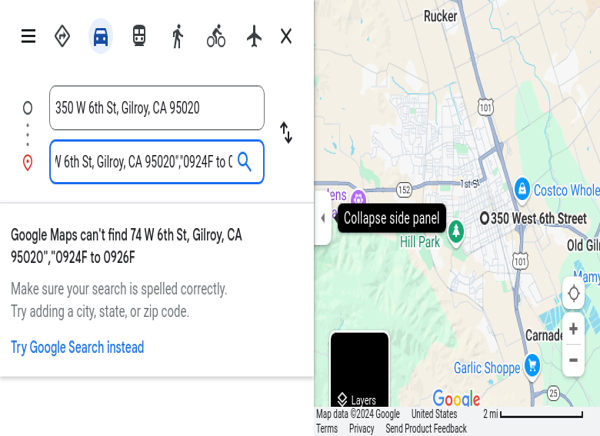

In [ ]:
img